In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import ruptures as rp
from prediction_pipeline.preprocessing import *
from sklearn.linear_model import LinearRegression
from glob import glob
import json


In [2]:
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"

# Sysmex SCT

In [3]:
sys_sct = load_Sysmex(data_dir,root_dir="CBR 159")
sys_sct.rename(columns={"Side Fluorescence Signal":"SFL",
                                  "Forward Scatter Signal":"FSC",
                                  "Forward Scatter Pulse Width Signal":"FSCW",
                                  "Side Scatter Signal":"SSC"},inplace=True)
sys_sct = sys_sct[["ID"] + FACS_COLS]
sys_sct[FACS_COLS] = sys_sct[FACS_COLS].astype(int)

629 candidates Sysmex WB files
Two files for ID C19XNH_ADP
Second file is CBR 159/x17092018_2x/FCS/[XN-20^12829][00-22A (Build 7)][Fcs][17092018_115032][C19XNH_ADP][PLT-F].fcs


In [4]:
id_cols = sys_sct["ID"].str.split("_",expand=True).rename(columns={0:"ID",1:"EXP"})
del sys_sct["ID"]
sys_sct = pd.concat([id_cols,sys_sct],axis=1)

In [5]:
sys_sct.head()

,ID,EXP,FSC,SSC,SFL
0,C19XB4,REST,207,102,241
1,C19XB4,REST,55,41,61
2,C19XB4,REST,47,45,55
3,C19XB4,REST,45,28,54
4,C19XB4,REST,71,58,72


In [6]:
sys_sct_WB = load_Sysmex(data_dir)
sys_sct_WB.rename(columns={"Side Fluorescence Signal":"SFL",
                                  "Forward Scatter Signal":"FSC",
                                  "Forward Scatter Pulse Width Signal":"FSCW",
                                  "Side Scatter Signal":"SSC"},inplace=True)
sys_sct_WB = sys_sct_WB[["ID"] + FACS_COLS]
sys_sct_WB[FACS_COLS] = sys_sct_WB[FACS_COLS].astype(int)
sys_sct_WB["EXP"] = "WB"
sys_sct_WB = sys_sct_WB[["ID","EXP","FSC","SSC","SFL"]]

648 candidates Sysmex WB files
Two files for ID C18PNK
Second file is Sysmex whole blood/October 2017/11112017/10112017_C18PNK/FCS/[XN-20^12829][00-22A (Build 7)][Fcs][10112017_103414][C18PNKFB][PLT-F].fcs
Two files for ID C18PPG
Second file is Sysmex whole blood/October 2017/11112017/10112017_C18PPG/FCS/[XN-20^12829][00-22A (Build 7)][Fcs][10112017_120048][C18PPGFB][PLT-F].fcs
Two files for ID C18JSY
Second file is Sysmex whole blood/October 2017/02102017_C18JSY/02102017_positive/02102017_C18JSY/FCS/[XN-20^12829][00-22A (Build 7)][Fcs][02102017_092024][C18JSYFB][PLT-F].fcs
Two files for ID C18JSY
Second file is Sysmex whole blood/October 2017/02102017_C18JSY/02102017_positive/02102017_C18JSY/repeat/FCS/[XN-20^12829][00-22A (Build 7)][Fcs][02102017_093246][C18JSYFB][PLT-F].fcs
Two files for ID C19759
Second file is Sysmex whole blood/April 2018/16042018/C19759_16042018/FCS/[XN-20^12829][00-22A (Build 7)][Fcs][16042018_152026][C19759FB][PLT-F].fcs
Two files for ID C0WX14
Second file is 

In [7]:
sys_sct = pd.concat([sys_sct,sys_sct_WB],axis=0)

In [8]:
sys_sct.head()

,ID,EXP,FSC,SSC,SFL
0,C19XB4,REST,207,102,241
1,C19XB4,REST,55,41,61
2,C19XB4,REST,47,45,55
3,C19XB4,REST,45,28,54
4,C19XB4,REST,71,58,72


In [9]:
sys_sct.shape[0] / int(1e6)

22.913852

(array([3.82778050e-05, 0.00000000e+00, 1.14833415e-04, 2.29666830e-04,
        6.50722685e-04, 8.03833905e-04, 1.11005634e-03, 4.59333660e-04,
        3.44500245e-04, 2.29666830e-04]),
 array([1475. , 1726.2, 1977.4, 2228.6, 2479.8, 2731. , 2982.2, 3233.4,
        3484.6, 3735.8, 3987. ]),
 <a list of 1 Patch objects>)

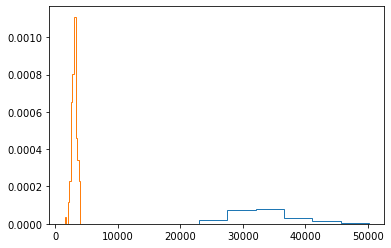

In [13]:
plt.hist(sys_sct.loc[sys_sct.EXP == "WB"].ID.value_counts(),histtype="step",density=True)
plt.hist(sys_sct.loc[sys_sct.EXP == "REST"].ID.value_counts(),histtype="step",density=True)

# Filter platelets

In [21]:
def polygon_with_offset(offset):
    alpha = ((120+.6*offset) - (25+ .5*offset)) / (85 - 25)
    
    p = np.array([[22,25,30,85 ,140,200,200,80,50,22],
                  [5 + .3*offset ,25+ .5*offset,max(35+.5*offset,25+.5*offset + alpha*5),120+.6*offset,180+.6*offset,220,160,15,0,5+ .3*offset]])
    p[0,5:-1] += 10
    #p[0] -= offset
    return p.T

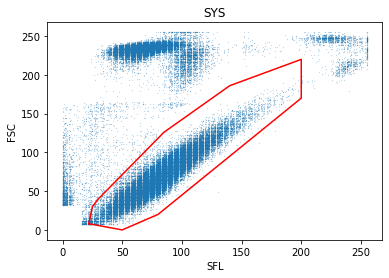

In [23]:
plt.figure()
sub_int_sct = sys_sct.sample(int(1e5))
plt.scatter(sub_int_sct.SFL,
            sub_int_sct.FSC,s=.01)

offset = 10
polygon = polygon_with_offset(offset)
path = mplPath.Path(polygon)

plt.plot(polygon[:,0],polygon[:,1],c="red")

plt.xlabel("SFL")
plt.ylabel("FSC")

plt.title("SYS");

In [ ]:
plt.figure()
sub_int_sct = sys_sct.loc[s].sample(int(1e5))
plt.scatter(sub_int_sct.SFL,
            sub_int_sct.FSC,s=.01)

offset = 10
polygon = polygon_with_offset(offset)
path = mplPath.Path(polygon)

plt.plot(polygon[:,0],polygon[:,1],c="red")

plt.xlabel("SFL")
plt.ylabel("FSC")

plt.title("SYS");

In [24]:
offset = 10
polygon = polygon_with_offset(offset)
path = mplPath.Path(polygon)

In [25]:
sys_sct["PLT"] = path.contains_points(sys_sct[["SFL","FSC"]])

In [27]:
sys_plt = sys_sct.loc[sys_sct.PLT,["ID","EXP","FSC","SSC","SFL"]]

In [31]:
sub_samples = []
for key, df in sys_plt.groupby(["ID","EXP"]):
    sub_samples.append(df.sample(500,replace=True))

In [32]:
short_df = pd.concat(sub_samples,axis=0)

In [39]:
short_df.loc[short_df.EXP == "RESTING","EXP"] = "REST"
short_df.loc[short_df.EXP == "Resting","EXP"] = "REST"
short_df = short_df.loc[short_df.EXP.isin(["WB","ADP","CRP","REST"])]

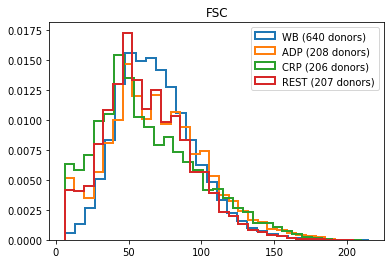

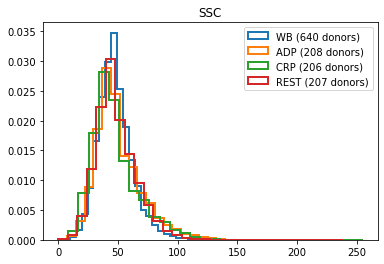

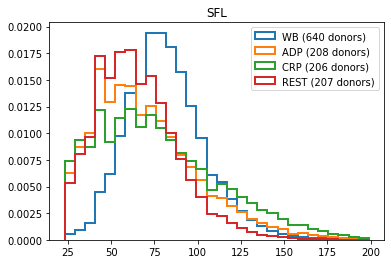

In [42]:
for col in ["FSC","SSC","SFL"]:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for exp in short_df.EXP.unique():
        ax.hist(short_df.loc[short_df.EXP == exp,col],density=True,histtype="step",label="%s (%d donors)" % (exp,short_df.loc[short_df.EXP == exp,"ID"].nunique()),bins=30,lw=2)
    ax.legend()
    ax.set_title(col)
    

# Compare counts

In [18]:
PLT = pd.concat([int_plt,sys_plt],axis=0).reset_index()
del PLT["index"]
PLT_count = PLT.ID.value_counts()

In [29]:
PLT.head()

,ID,FSC,SSC,SFL
0,INT_116_4555900,54,28,82
1,INT_116_4555900,58,36,102
2,INT_116_4555900,42,24,62
3,INT_116_4555900,24,21,45
4,INT_116_4555900,74,47,74


In [21]:
def save_in_slices(df, folder):
    chunk_size = int(1e6)
    n_chunks = df.shape[0] // chunk_size
    for n_chunk in tqdm(range(n_chunks)):
        i = n_chunk*chunk_size
        j = min(i + chunk_size,df.shape[0])
        df_ = df.iloc[i:j].copy()
        df_.to_hdf("%s/chunk_%d.hdf" % (folder,n_chunk),key="key")

In [ ]:
save_in_slices(PLT,"%s/processed/PLT_unadjusted" % data_dir)

In [19]:
sysmex_features = pd.read_csv("%s/processed/sysmex_features.csv" % data_dir,index_col=0)

In [20]:
sysmex_features.head(3)

,PLT,MPV,PDW,PCT,IPF
C0WX8R,248.915732,11.908765,15.050636,0.290577,4.849356
C0WX14,264.915732,10.308765,11.950636,0.250577,2.749356
C0WX6V,264.915732,11.108765,13.350636,0.280577,3.949356


In [21]:
PLT_count_compare = pd.merge(pd.DataFrame(PLT_count),sysmex_features,left_index=True,right_index=True,how='inner')

In [22]:
PLT_count_compare.head(3)

,ID,PLT,MPV,PDW,PCT,IPF
INT_116_2137000,63526,975.891013,11.929374,16.083966,1.188759,4.28012
INT_116_7209600,62987,801.795602,10.008924,12.067735,0.793207,1.04059
INT_116_4565100,62260,781.891013,10.929374,13.383966,0.868759,2.98012


In [23]:
int_IDs = [i for i in PLT_count_compare.index.tolist() if "INT" in i]

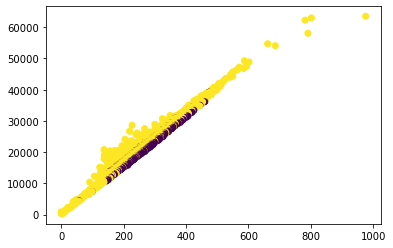

In [24]:
# Plot by cohort
plt.scatter(PLT_count_compare.PLT,PLT_count_compare.ID,c=PLT_count_compare.index.isin(int_IDs))

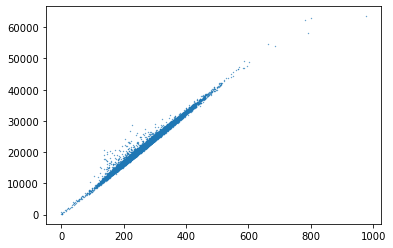

In [25]:
plt.scatter(PLT_count_compare.loc[PLT_count_compare.index.isin(int_IDs)].PLT,
            PLT_count_compare.loc[PLT_count_compare.index.isin(int_IDs)].ID,s=.1)

In [26]:
int_PLT_count_compare = PLT_count_compare.loc[PLT_count_compare.index.isin(int_IDs)]

In [28]:
(int_PLT_count_compare["ID"] <= 2000).sum()

14

In [29]:
lm = LinearRegression(fit_intercept=False)
lm.fit(int_PLT_count_compare[["PLT"]],int_PLT_count_compare["ID"])
interp = lm.predict(int_PLT_count_compare[["PLT"]])
err = np.abs(int_PLT_count_compare["ID"]-interp)

149


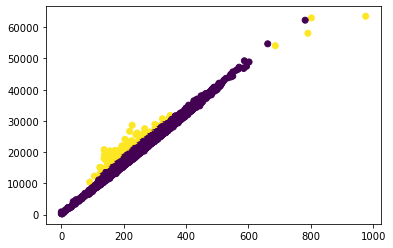

In [30]:
# Plot by error
err_threshold = 2000
print(np.sum(err > err_threshold))
plt.scatter(int_PLT_count_compare.PLT,int_PLT_count_compare.ID,c=err > err_threshold)

In [31]:
err_IDs = int_PLT_count_compare.loc[err > err_threshold].index.tolist()

KeyboardInterrupt: 

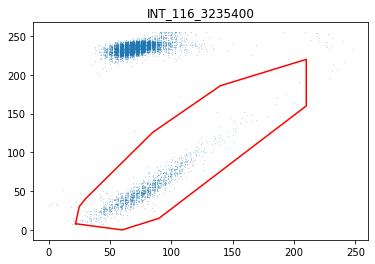

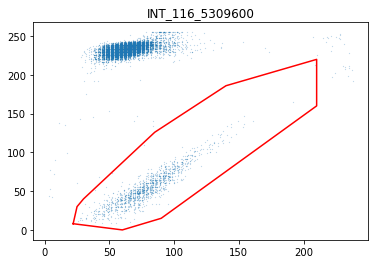

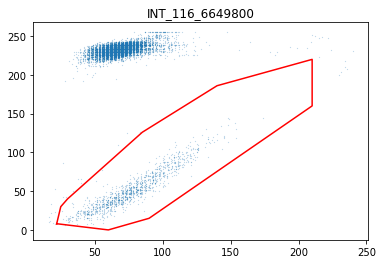

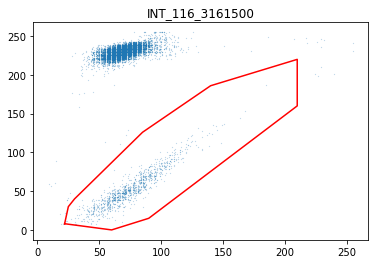

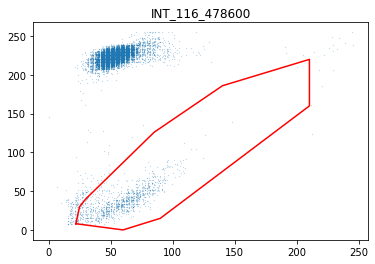

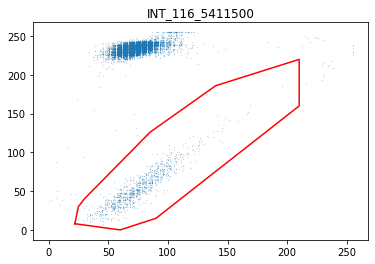

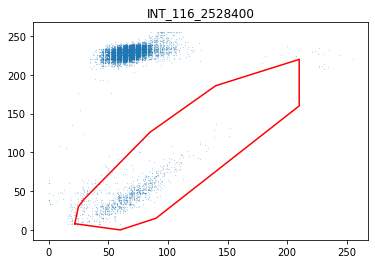

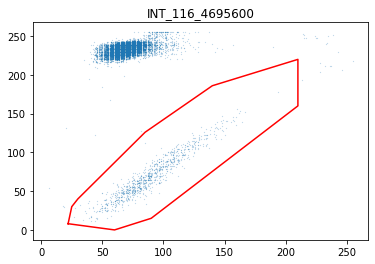

<Figure size 432x288 with 0 Axes>

In [52]:
# Look at error scattergrams
for ID in err_IDs:
    plt.figure()
    if ID in sys_sct.ID.tolist():
        cond = sys_sct.ID == ID
        plt.scatter(sys_sct.loc[cond,"SFL"],sys_sct.loc[cond,"FSC"],s=.01)
    else:
        cond = int_sct.ID == ID
        plt.scatter(int_sct.loc[cond,"SFL"],int_sct.loc[cond,"FSC"],s=.01)
    plt.plot(polygon[:,0],polygon[:,1],c="red")
    plt.title(ID)

In [32]:
def sample(df):
    return df.sample(2000,replace=True) 

In [33]:
PLT = PLT.groupby("ID").apply(sample)

In [34]:
PLT = PLT[FACS_COLS].reset_index()
del PLT["level_1"]

In [35]:
PLT = PLT.loc[~PLT.ID.isin(err_IDs)]

In [36]:
PLT.shape[0] // int(1e6)

66

# Compare histograms of signal

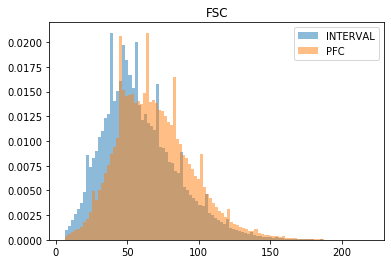

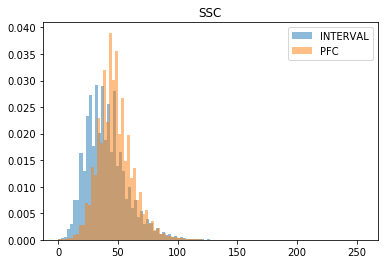

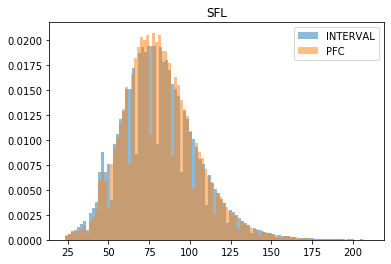

In [29]:
def subsample(x):
    return x.sample(1000,replace=True)

for c in FACS_COLS:
    plt.figure()
    plt.hist(int_plt.groupby("ID").apply(subsample)[c],bins=100,density=True,alpha=.5,label="INTERVAL")
    plt.hist(sys_plt.groupby("ID").apply(subsample)[c],bins=100,density=True,alpha=.5,label="PFC")
    plt.title(c)
    plt.legend()

Text(0, 0.5, 'SFL')

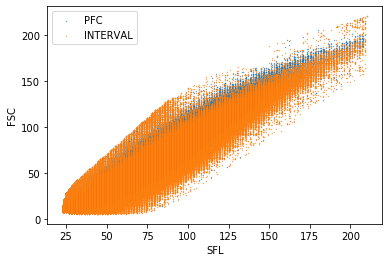

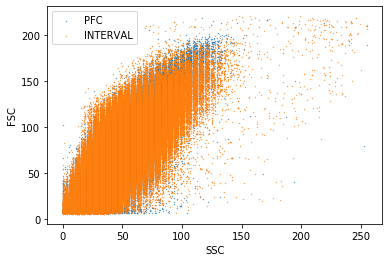

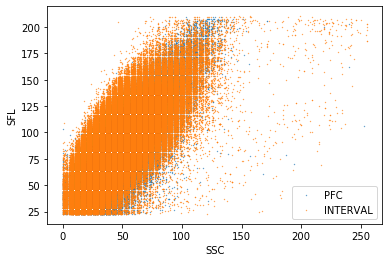

In [29]:
sub_sys_sct = sys_plt.groupby("ID").apply(subsample)
sub_int_sct = int_plt.groupby("ID").apply(subsample)
plt.figure()
plt.scatter(sub_sys_sct["SFL"],sub_sys_sct["FSC"],s=.1,label="PFC")
plt.scatter(sub_int_sct["SFL"],sub_int_sct["FSC"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SFL")
plt.ylabel("FSC")

plt.figure()
plt.scatter(sub_sys_sct["SSC"],sub_sys_sct["FSC"],s=.1,label="PFC")
plt.scatter(sub_int_sct["SSC"],sub_int_sct["FSC"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SSC")
plt.ylabel("FSC")

plt.figure()
plt.scatter(sub_sys_sct["SSC"],sub_sys_sct["SFL"],s=.1,label="PFC")
plt.scatter(sub_int_sct["SSC"],sub_int_sct["SFL"],s=.1,label="INTERVAL")
plt.legend()

plt.xlabel("SSC")
plt.ylabel("SFL")

# Make sub-cohorts in Sysmex cohort

In [37]:
sys_mean_values = PLT.loc[PLT.ID.isin(sys_plt.ID.unique().tolist())].groupby("ID")[FACS_COLS].mean()

In [38]:
sys_phen = load_sys_phenotypes(data_dir)
sys_phen["time_col"] = pd.to_datetime(sys_phen["Date"],format="%d/%m/%Y")
sys_phen.sort_values("time_col",inplace=True)

602 candidates summary files
Initially 1068 rows, 643 unique IDs
Finally 642 rows, 642 unique IDs


In [39]:
sys_info = pd.merge(sys_mean_values,sys_phen.set_index("ID")[["time_col"]],left_index=True,right_index=True).sort_values("time_col")

In [40]:
sys_info.head()

,FSC,SSC,SFL,time_col
ID,,,,
C0WX14,64.9730,45.6270,77.2565,2016-01-12
C0WX4Z,70.9520,48.1920,78.6535,2016-01-12
C0WX6V,69.6905,48.0875,80.1475,2016-01-12
C0WX7T,70.9550,50.2380,83.7305,2016-01-12
C0WX8R,73.4380,47.8450,82.2085,2016-01-12


In [41]:
X = sys_info[FACS_COLS].values

In [42]:
algo_c = rp.KernelCPD(kernel="rbf", min_size=80).fit(
    X
)

6 BKPS


<Figure size 720x288 with 0 Axes>

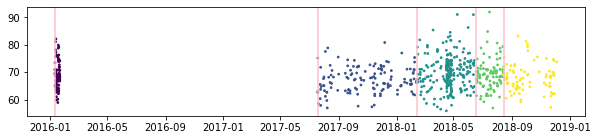

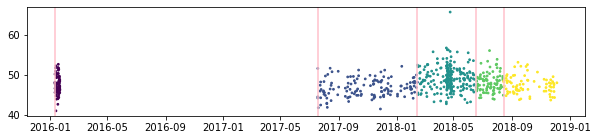

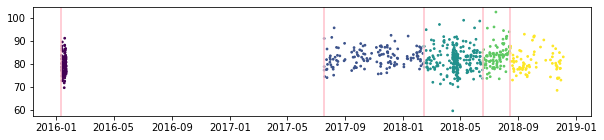

In [43]:
bkps = algo_c.predict(pen=1.6)
bkps = [0] + bkps
print("%d BKPS" % len(bkps))

sys_info["cohort"] = 0
sys_info["rank"] = np.arange(sys_info.shape[0])
for b in bkps[1:]:
    sys_info.loc[sys_info["rank"] >= b,"cohort"] += 1
    
plt.figure(figsize=(10,4))
for i in range(X.shape[1]):
    plt.figure(figsize=(10,2))
    plt.scatter(sys_info["time_col"],X[:,i],s=3,c=sys_info.cohort)
    for b in bkps[:-1]:
        plt.axvline(sys_info["time_col"].iloc[b],c="pink")

# Make sub-cohorts in Interval cohorts

In [44]:
int_phen, meta = get_INTERVAL_phenotypes()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max


In [45]:
int_mean_values = PLT.loc[PLT.ID.isin(int_plt.ID.unique().tolist())].groupby("ID")[FACS_COLS].mean()

26 BKPS
18 BKPS


<Figure size 720x288 with 0 Axes>

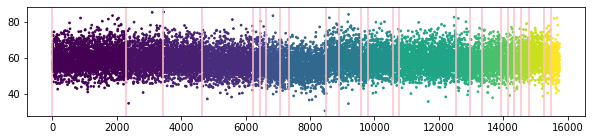

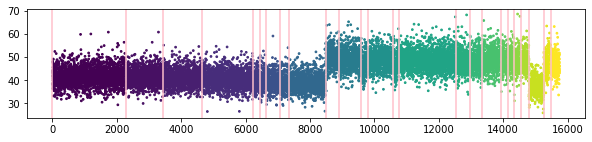

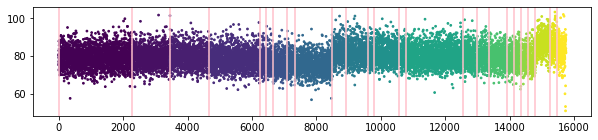

<Figure size 720x288 with 0 Axes>

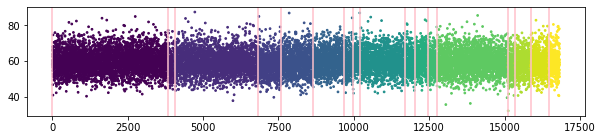

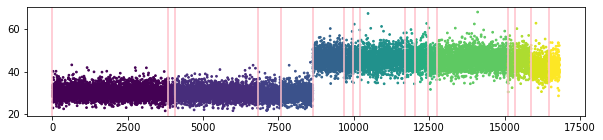

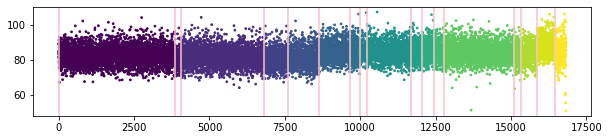

In [48]:
cohort_offset = sys_info.cohort.max() + 1
machines = int_phen["Instrument"].unique().tolist()
int_infos = []
for instrument in machines:
    int_info = pd.merge(int_mean_values, int_phen.loc[int_phen.Instrument == instrument,
                                                      ["SampleNo","DateTime"]],
                        left_index=True,right_on="SampleNo",how="inner")
    
    int_info.sort_values("DateTime",inplace=True)
    X = int_info[FACS_COLS].values
    
    algo_c = rp.KernelCPD(kernel="rbf", min_size=200).fit(
        X
    )
    
    bkps = algo_c.predict(pen=1.6)
    bkps = [0] + bkps
    print("%d BKPS" % len(bkps))

    int_info["cohort"] = cohort_offset
    int_info["rank"] = np.arange(int_info.shape[0])
    for b in bkps[1:]:
        int_info.loc[int_info["rank"] >= b,"cohort"] += 1

    plt.figure(figsize=(10,4))
    for i in range(X.shape[1]):
        plt.figure(figsize=(10,2))
        plt.scatter(int_info["rank"],X[:,i],s=3,c=int_info.cohort)
        for b in bkps[:-1]:
            plt.axvline(int_info["rank"].iloc[b],c="pink")
    int_infos.append(int_info)
    cohort_offset = int_info.cohort.max() + 1
int_info = pd.concat(int_infos,axis=0)

In [49]:
int_info.head()

,FSC,SSC,SFL,SampleNo,DateTime,cohort,rank
0,56.9270,38.4280,75.3135,INT_116_6580100,2013-03-01 10:19:44,5,0
1,63.0295,43.5340,80.5020,INT_116_6580000,2013-03-01 10:21:00,5,1
2,58.0920,38.5090,79.1985,INT_116_4555900,2013-03-01 10:23:33,5,2
3,63.6930,44.0130,82.9610,INT_116_4555800,2013-03-01 10:24:49,5,3
4,55.9965,41.7445,77.2415,INT_116_4556000,2013-03-01 10:26:06,5,4


# Load age & sex

In [50]:
sys_agesex, int_agesex = get_ages_sex()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max


# Gather all

In [51]:
sys_all = pd.merge(sys_agesex,sys_info,left_index=True,right_index=True,how="inner").sort_values("time_col")
sys_all.head()

,SEX,AGE,FSC,SSC,SFL,time_col,cohort,rank
C0WX14,2,67.0,64.9730,45.6270,77.2565,2016-01-12,0,0
C0WX4Z,2,63.0,70.9520,48.1920,78.6535,2016-01-12,0,1
C0WX6V,2,64.0,69.6905,48.0875,80.1475,2016-01-12,0,2
C0WX7T,2,70.0,70.9550,50.2380,83.7305,2016-01-12,0,3
C0WX8R,2,71.0,73.4380,47.8450,82.2085,2016-01-12,0,4


In [52]:
sys_all.tail()

,SEX,AGE,FSC,SSC,SFL,time_col,cohort,rank
C1A2PI,1,69.0,69.842,46.9700,77.9715,2018-11-28,4,634
C1A2RE,1,60.0,74.231,47.5885,81.5215,2018-11-29,4,635
C1A2TA,2,42.0,68.839,45.8700,78.1175,2018-11-29,4,636
C1A2X2,1,71.0,62.175,44.3485,72.9405,2018-11-30,4,637
C1A32N,2,44.0,73.712,48.0575,83.0840,2018-12-05,4,638


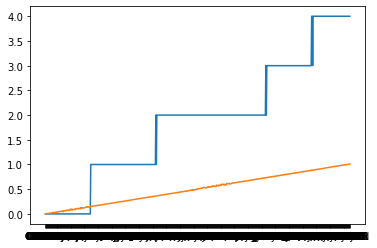

In [74]:
plt.plot(sys_all.cohort)
plt.plot(sys_all["rank"] / sys_all.shape[0])

In [53]:
int_all = pd.merge(int_agesex,int_info,left_index=True,right_on="SampleNo",how="inner").set_index("SampleNo").sort_values("DateTime")
int_all.head()

,SEX,AGE,FSC,SSC,SFL,DateTime,cohort,rank
SampleNo,,,,,,,,
INT_116_6580100,1,58.8,56.9270,38.4280,75.3135,2013-03-01 10:19:44,5,0
INT_116_6580000,2,22.6,63.0295,43.5340,80.5020,2013-03-01 10:21:00,5,1
INT_116_4555900,2,59.4,58.0920,38.5090,79.1985,2013-03-01 10:23:33,5,2
INT_116_4555800,2,21.3,63.6930,44.0130,82.9610,2013-03-01 10:24:49,5,3
INT_116_4556000,1,49.3,55.9965,41.7445,77.2415,2013-03-01 10:26:06,5,4


In [54]:
all_ = pd.concat((sys_all[["SEX","AGE","cohort"]+FACS_COLS],
                  int_all[["SEX","AGE","cohort"]+FACS_COLS]),axis=0)
X = pd.concat([all_[["SEX","AGE"]],pd.get_dummies(all_["cohort"],drop_first=True)],axis=1)
Y = all_[FACS_COLS]
# IT IS DEGENERATE IF WE DON'T DROP THE FIRST LEVEL

In [55]:
X.sample(3)

,SEX,AGE,1,2,3,4,5,6,7,8,...,37,38,39,40,41,42,43,44,45,46
INT_116_821000,1,49.9,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
INT_116_2424100,2,42.9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
INT_116_3213900,2,20.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [56]:
Y.sample(3)

,FSC,SSC,SFL
INT_116_3382700,61.2060,37.0335,88.6845
INT_116_6894800,54.7340,37.7835,74.8280
INT_116_5552400,55.0985,45.4790,82.4940


In [57]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X,Y)
cohort_coefs = lm.coef_[:,2:]
print(cohort_coefs.shape)

(3, 46)


In [58]:
cohort_coefs

array([[ -2.65226446,   0.19139113,  -0.4419378 ,  -1.36304929,
        -10.58180005, -10.74206789, -11.40950372, -12.9616594 ,
        -13.83667026, -11.704959  , -13.82235875, -14.70517324,
        -15.19775339, -10.32064494, -11.0947997 , -13.39867717,
        -11.07993231, -12.02000404, -11.40434253, -12.23717413,
        -13.23848014, -11.16319444, -12.63583659, -11.027024  ,
        -12.48906656, -10.84070141,  -9.84475429, -10.65081342,
        -12.18900396, -10.36031419, -12.45933363, -10.81183212,
        -12.41132892, -11.05635316, -10.27908329, -11.00726928,
         -9.34225868, -10.033004  , -10.75623247,  -9.15514587,
        -11.20623231, -10.45286442, -13.05206031, -11.46327738,
        -10.55959429, -10.26116775],
       [ -1.20306482,   1.28880059,   0.28541123,  -0.13682241,
         -6.59652102,  -6.81526403,  -7.2831772 ,  -7.91344012,
         -8.75981477,  -7.56189545,  -8.46742699,  -9.03838858,
         -9.33326933,   1.3634409 ,   0.78476697,  -1.71850274,
   

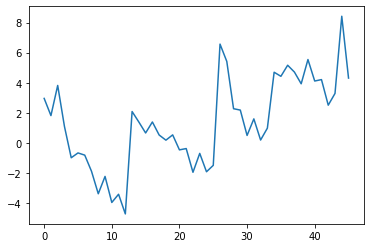

In [59]:
plt.plot(cohort_coefs[2])

In [82]:
## 
##WARNING 
## This actually changes the data

In [60]:
for c in all_.cohort.unique().tolist():
    if c == 0: continue
    PLT.loc[PLT.ID.isin(all_.loc[all_.cohort == c].index.tolist()),FACS_COLS] -= cohort_coefs[:,c-1]

In [61]:
mean_values = PLT.groupby("ID")[FACS_COLS].mean()

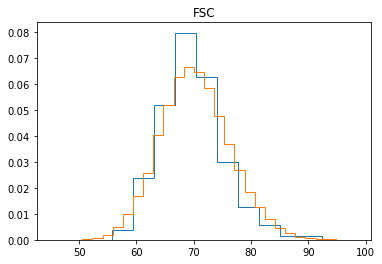

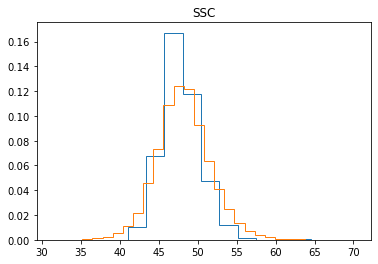

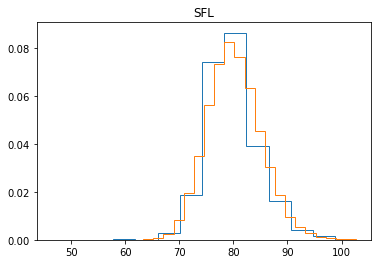

In [62]:
for c in FACS_COLS:
    plt.figure()
    plt.hist(mean_values.loc[mean_values.index.isin(sys_plt.ID.unique().tolist()),c],label="Sysmex Cohort",histtype="step",density=True)
    plt.hist(mean_values.loc[~mean_values.index.isin(sys_plt.ID.unique().tolist()),c],label="INTERVAL Cohort",histtype="step",density=True,bins=30)
    plt.title(c)

In [63]:
PLT.to_hdf("%s/processed/PLT.hdf" % data_dir,key="PLT")